In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        print("Q_output size:", Q_output.size())
        print("K_output size:", K_output.size())
        print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [1, 7])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [1, 7])
X_test, y_test = X_test[test_mask], y_test[test_mask]

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [6]:
X_train.shape

(283, 8, 8)

In [7]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [8]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [9]:
# (283, 16, 2, 2)를 (283, 16, 4)로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [10]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [11]:
X_train.shape

(283, 4, 16)

In [12]:
X_train

array([[[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [16., 16., 13., ..., 11.,  1.,  0.],
        [ 0.,  0.,  2., ...,  0.,  2., 15.],
        [15., 16.,  9., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  4., ...,  0.,  1.,  9.],
        [16., 11.,  0., ..., 16., 10.,  0.],
        [ 0.,  0., 13., ...,  0.,  6., 11.],
        [16.,  8.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  6., ...,  2.,  6., 12.],
        [14.,  1.,  0., ...,  7.,  2.,  0.],
        [ 0., 13., 16., ...,  0., 10.,  8.],
        [16., 16.,  9., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  3., 15., ...,  0., 11., 13.],
        [15.,  3.,  0., ..., 16.,  8.,  0.],
        [ 0.,  1., 15., ...,  3., 16.,  5.],
        [15.,  7.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  7., 12.,  0.],
        [16., 10.,  0., ..., 11.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1., 15.],
        [15., 16.,  7., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  0.,  9., 16.],
        [11.,  1.,  0., ...,  0.

In [13]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [14]:
model=QSANN_text_classifier(4, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [15]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [16]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

209


In [17]:
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [19]:
torch.tensor(X_train)

tensor([[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
         [16., 16., 13.,  ..., 11.,  1.,  0.],
         [ 0.,  0.,  2.,  ...,  0.,  2., 15.],
         [15., 16.,  9.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  4.,  ...,  0.,  1.,  9.],
         [16., 11.,  0.,  ..., 16., 10.,  0.],
         [ 0.,  0., 13.,  ...,  0.,  6., 11.],
         [16.,  8.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  6.,  ...,  2.,  6., 12.],
         [14.,  1.,  0.,  ...,  7.,  2.,  0.],
         [ 0., 13., 16.,  ...,  0., 10.,  8.],
         [16., 16.,  9.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  3., 15.,  ...,  0., 11., 13.],
         [15.,  3.,  0.,  ..., 16.,  8.,  0.],
         [ 0.,  1., 15.,  ...,  3., 16.,  5.],
         [15.,  7.,  2.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  7., 12.,  0.],
         [16., 10.,  0.,  ..., 11.,  0.,  0.],
         [ 0.,  1.,  2.,  ...,  0.,  1., 15.],
         [15., 16.,  7.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  ...,  0., 

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9835, 0.9222, 0.9516, 0.7586],
         [0.9995, 0.9689, 0.9867, 0.8393],
         [0.9980, 0.9608, 0.9811, 0.8233],
         [0.9998, 0.9801, 0.9936, 0.8637]],

        [[0.9463, 0.8766, 0.7746, 0.5261],
         [0.9735, 0.9183, 0.8281, 0.5866],
         [0.9995, 0.9778, 0.9181, 0.7074],
         [0.9942, 0.9973, 0.9630, 0.7863]],

        [[0.9931, 0.9925, 0.9875, 0.9267],
         [0.9882, 0.9875, 0.9812, 0.9130],
         [0.9417, 0.9403, 0.9278, 0.8257],
         [0.9569, 0.9581, 0.9677, 0.9997]],

        ...,

        [[0.9991, 0.9938, 0.9991, 0.9639],
         [0.9909, 0.9978, 0.9763, 0.9041],
         [0.9969, 1.0000, 0.9869, 0.9259],
         [0.9844, 0.9700, 0.9956, 0.9908]],

        [[0.9991, 0.9984, 0.9876, 0.8646],
         [0.9954, 0.9938, 0.9777, 0.8385],
         [0.9741, 0.9773, 0.9936, 0.9648],
         [0.9986, 0.9993, 0.9980, 0.9061]],

        [[0.8990, 0.9740, 0.9995, 0.8867],
         [0.9950, 0.9913, 0.9473, 0.9917],
         [0.9451, 0.994

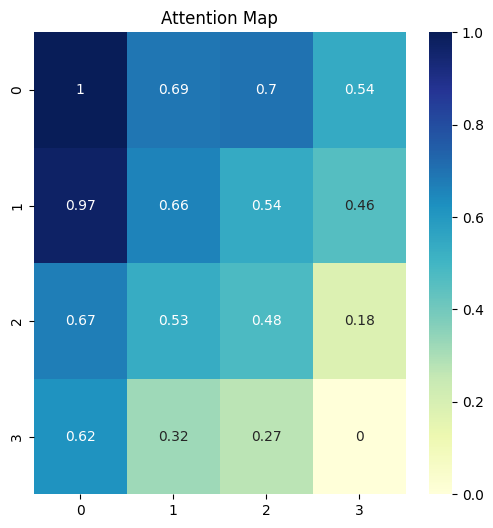

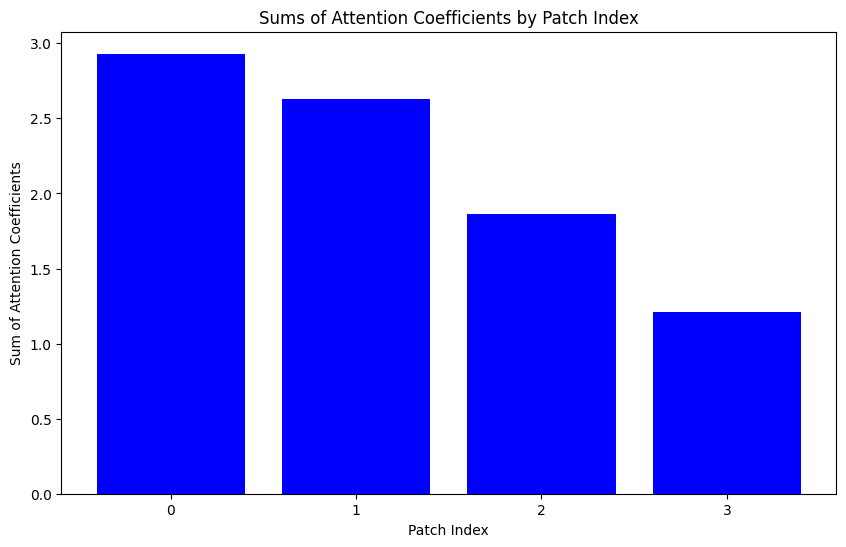

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])

Accuracy: tensor(0.5830)

tensor(766.9174, grad_fn=<DivBackward1>)


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
 10%|█         | 1/10 [01:20<12:04, 80.55s/it]

Complete 0 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9957, 0.9922, 0.9982, 0.9402],
         [0.9731, 0.9799, 0.9279, 0.7947],
         [0.9996, 1.0000, 0.9838, 0.8948],
         [1.0000, 0.9997, 0.9868, 0.9021]],

        [[0.9403, 0.9351, 0.9169, 0.8406],
         [0.8918, 0.8851, 0.9592, 0.7733],
         [0.9993, 0.9986, 0.7662, 0.9626],
         [0.8882, 0.8814, 0.9615, 0.7686]],

        [[0.9933, 0.9998, 0.9920, 0.9721],
         [0.9835, 0.9990, 0.9816, 0.9548],
         [0.9971, 0.9774, 0.9978, 0.9990],
         [0.9761, 0.9384, 0.9784, 0.9952]],

        ...,

        [[0.9668, 1.0000, 0.9890, 0.9868],
         [0.9350, 0.9951, 0.9679, 0.9984],
         [0.9913, 0.9230, 0.9708, 0.8571],
         [0.9999, 0.9686, 0.9954, 0.9203]],

        [[0.9983, 0.9935, 0.9997, 0.9971],
         [0.9882, 0.9785, 0.9974, 0.9998],
         [0.9765, 0.9634, 0.9908, 0.9966],
         [0.9970, 0.9913, 1.0000, 0.9983]],

        [[0.9998, 0.9744, 0.9735, 0.9936],
         [0.9715, 0.9995, 0.8870, 0.9336],
         [0.7289, 0.603

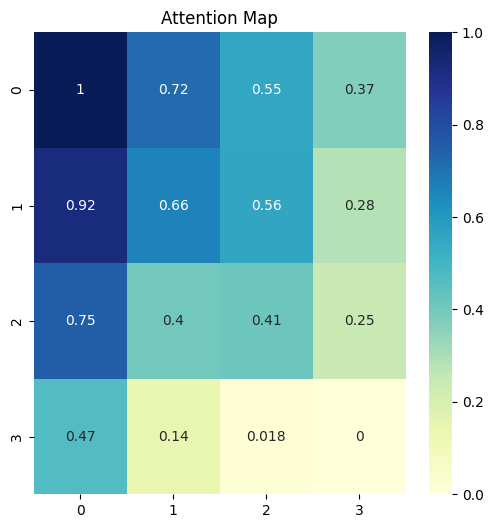

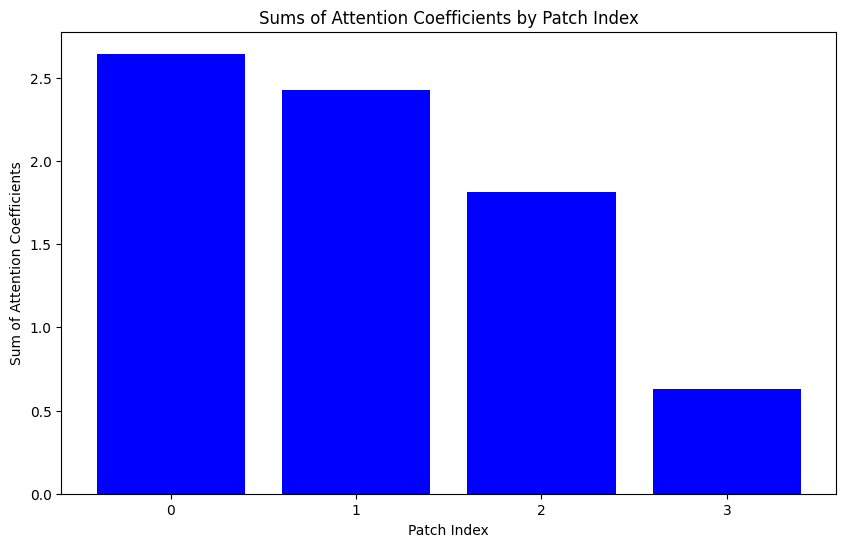

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8799)

tensor(747.4761, grad_fn=<DivBackward1>)


 20%|██        | 2/10 [02:46<11:08, 83.53s/it]

Complete 1 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9875, 0.7696, 0.9833, 0.8395],
         [0.9205, 0.9876, 0.9295, 0.9997],
         [0.9585, 0.9632, 0.9651, 0.9900],
         [0.9974, 0.8857, 0.9989, 0.9371]],

        [[0.9965, 0.9964, 0.9146, 0.8861],
         [0.9961, 0.9675, 0.9692, 0.9503],
         [0.9894, 0.9517, 0.9816, 0.9663],
         [0.9983, 0.9940, 0.9238, 0.8966]],

        [[0.9919, 0.9037, 0.9847, 0.9738],
         [0.9922, 0.9807, 0.9125, 0.8900],
         [0.9955, 0.9744, 0.9239, 0.9026],
         [0.9630, 0.8367, 0.9996, 0.9965]],

        ...,

        [[0.9968, 1.0000, 0.9863, 0.8527],
         [0.9477, 0.9184, 0.9711, 0.9878],
         [0.9847, 0.9959, 0.9665, 0.8045],
         [0.9710, 0.9478, 0.9878, 0.9713]],

        [[0.9912, 0.9996, 0.9922, 0.9989],
         [0.9926, 0.9998, 0.9908, 0.9993],
         [0.9230, 0.8806, 0.8053, 0.8890],
         [0.7913, 0.8451, 0.9131, 0.8356]],

        [[0.9935, 0.9671, 0.9072, 0.9930],
         [1.0000, 0.9902, 0.9491, 0.9723],
         [0.9923, 0.999

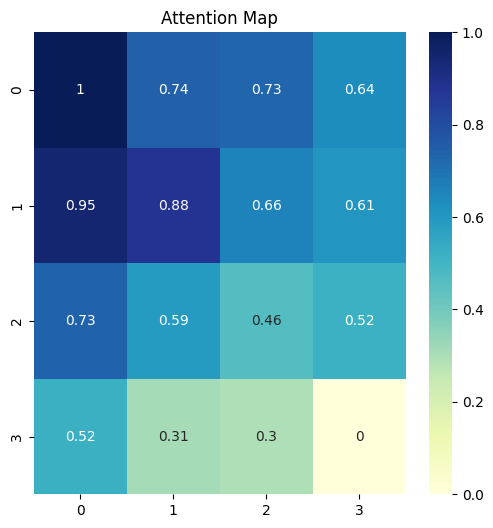

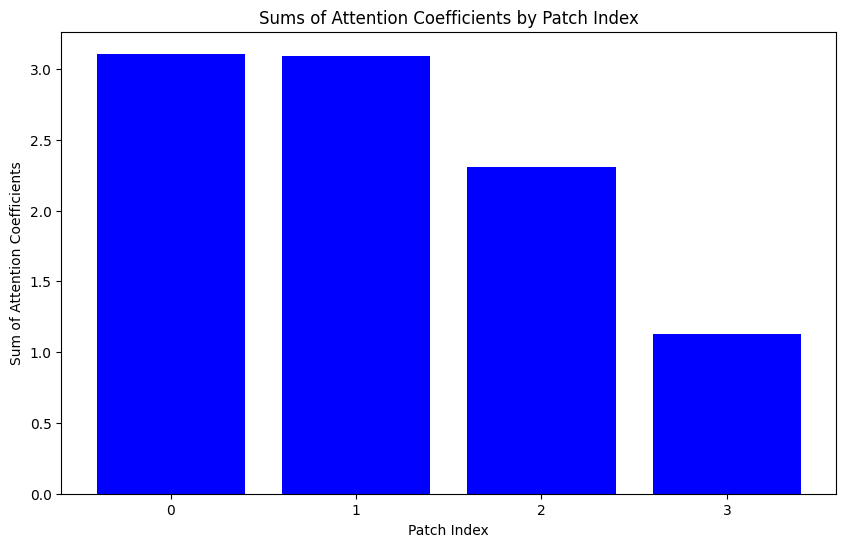

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8339)

tensor(744.3751, grad_fn=<DivBackward1>)


 30%|███       | 3/10 [04:13<09:55, 85.10s/it]

Complete 2 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9769, 0.9889, 0.9732, 0.8878],
         [0.9456, 0.9228, 0.9509, 0.9980],
         [0.9591, 0.9755, 0.9542, 0.8544],
         [1.0000, 0.9971, 1.0000, 0.9662]],

        [[0.9586, 0.9997, 0.8399, 0.7953],
         [0.8843, 0.9735, 0.7284, 0.6777],
         [0.9549, 0.9992, 0.8332, 0.7881],
         [0.9036, 0.9829, 0.7547, 0.7049]],

        [[0.9999, 0.9599, 0.9456, 0.9277],
         [0.9715, 0.8774, 0.8550, 0.8289],
         [0.9932, 0.9883, 0.9798, 0.9680],
         [0.9273, 0.9931, 0.9976, 0.9999]],

        ...,

        [[0.9976, 0.9881, 0.9967, 0.9377],
         [0.9544, 0.9264, 0.9882, 0.9925],
         [0.9396, 0.9084, 0.9799, 0.9972],
         [0.9871, 0.9971, 0.9523, 0.8405]],

        [[0.9880, 0.9999, 0.9993, 0.9259],
         [0.9938, 0.9680, 0.9741, 0.9922],
         [0.9765, 0.9972, 0.9950, 0.9018],
         [0.9995, 0.9938, 0.9963, 0.9646]],

        [[0.9906, 0.9668, 0.9833, 0.9932],
         [0.9828, 0.9534, 0.9910, 0.9977],
         [0.6927, 0.763

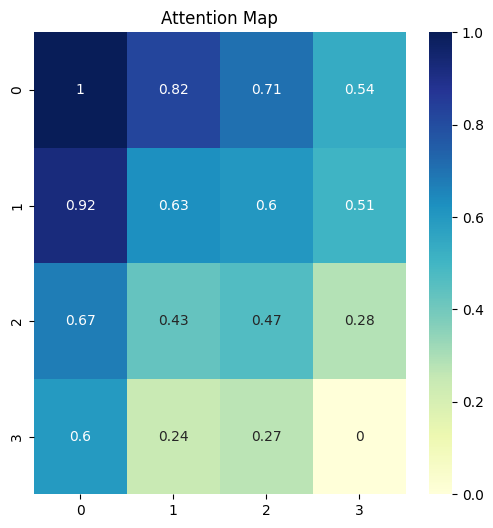

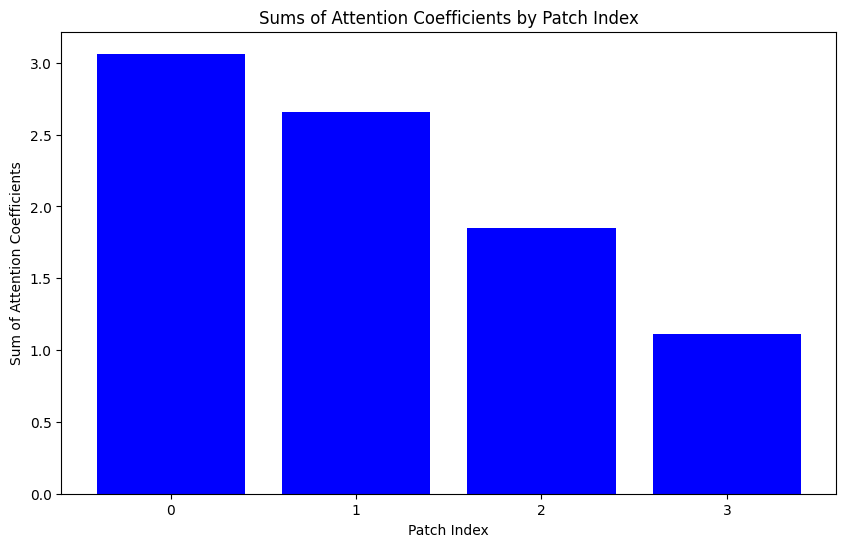

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.8516)

tensor(741.4448, grad_fn=<DivBackward1>)


 40%|████      | 4/10 [05:40<08:36, 86.13s/it]

Complete 3 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9958, 0.8884, 0.9986, 0.9866],
         [0.9979, 0.9001, 0.9997, 0.9907],
         [0.9796, 0.8366, 0.9868, 0.9628],
         [0.9595, 0.7926, 0.9698, 0.9373]],

        [[0.9040, 0.8783, 0.9998, 0.9152],
         [0.9576, 0.9390, 0.9909, 0.8473],
         [0.9551, 0.9709, 0.7646, 0.5024],
         [0.9841, 0.9929, 0.8310, 0.5767]],

        [[0.9995, 0.9300, 1.0000, 0.9998],
         [0.9457, 0.9970, 0.9534, 0.9602],
         [0.9202, 0.7144, 0.9104, 0.9008],
         [0.7946, 0.5519, 0.7808, 0.7675]],

        ...,

        [[0.9492, 0.9975, 0.9944, 0.9877],
         [0.9967, 0.9459, 0.9565, 0.8543],
         [0.9466, 0.9969, 0.9935, 0.9890],
         [0.9833, 0.9977, 0.9995, 0.9571]],

        [[0.9986, 0.9978, 0.9980, 0.9590],
         [0.9909, 0.9681, 0.9687, 0.9949],
         [0.9398, 0.8948, 0.8959, 0.9933],
         [0.8346, 0.7715, 0.7729, 0.9357]],

        [[0.9901, 0.9406, 1.0000, 0.9875],
         [0.9972, 0.9603, 0.9975, 0.9956],
         [0.7139, 0.588

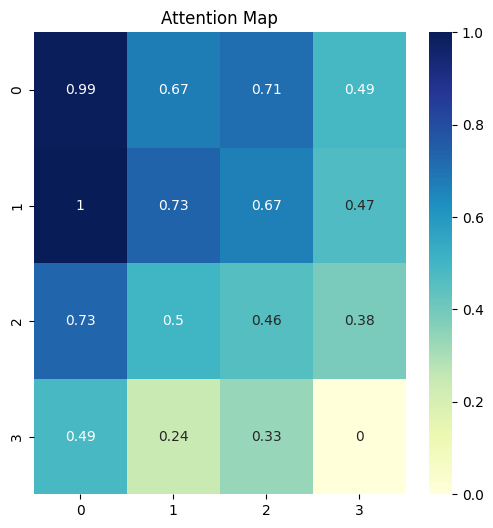

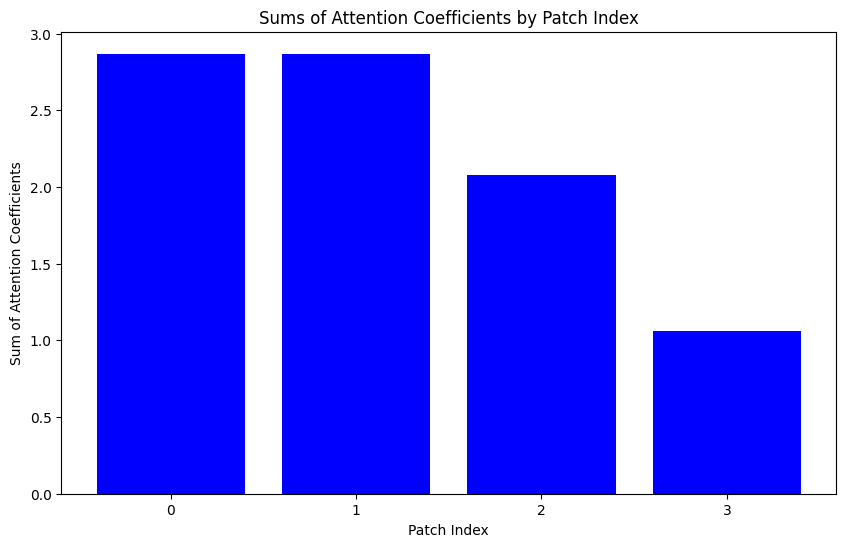

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9399)

tensor(734.9349, grad_fn=<DivBackward1>)


 50%|█████     | 5/10 [07:09<07:14, 86.88s/it]

Complete 4 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9964, 0.9990, 0.9951, 0.9600],
         [1.0000, 0.9921, 0.9840, 0.9791],
         [0.9921, 0.9676, 0.9529, 0.9972],
         [0.9831, 0.9985, 1.0000, 0.9283]],

        [[0.9978, 0.9917, 0.9387, 0.6955],
         [0.9609, 0.9422, 0.9903, 0.5653],
         [0.9737, 0.9578, 0.9819, 0.5965],
         [0.9981, 0.9923, 0.9371, 0.6984]],

        [[0.9979, 0.9357, 0.9985, 0.9885],
         [0.9768, 0.9966, 0.9450, 0.9916],
         [1.0000, 0.9569, 0.9925, 0.9965],
         [0.9560, 1.0000, 0.9158, 0.9776]],

        ...,

        [[0.9779, 1.0000, 0.9936, 0.9986],
         [0.9883, 0.9350, 0.9689, 0.9165],
         [0.9956, 0.9930, 1.0000, 0.9857],
         [1.0000, 0.9789, 0.9958, 0.9674]],

        [[0.9912, 0.9996, 0.9992, 0.9750],
         [1.0000, 0.9950, 0.9861, 0.9953],
         [0.9748, 0.9928, 0.9986, 0.9508],
         [0.8149, 0.8669, 0.8968, 0.7652]],

        [[0.9811, 0.9905, 0.9959, 0.9805],
         [0.9805, 0.9678, 0.8890, 0.9811],
         [0.9688, 0.981

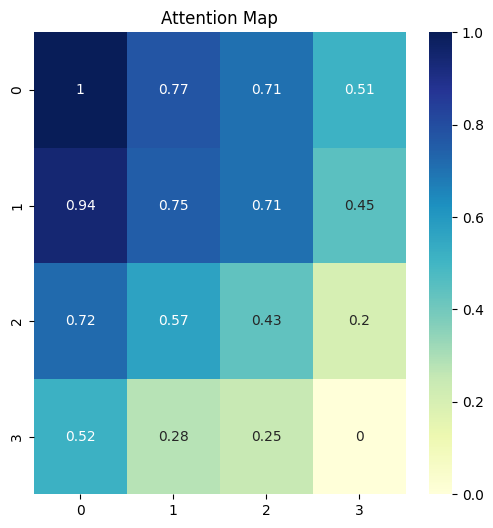

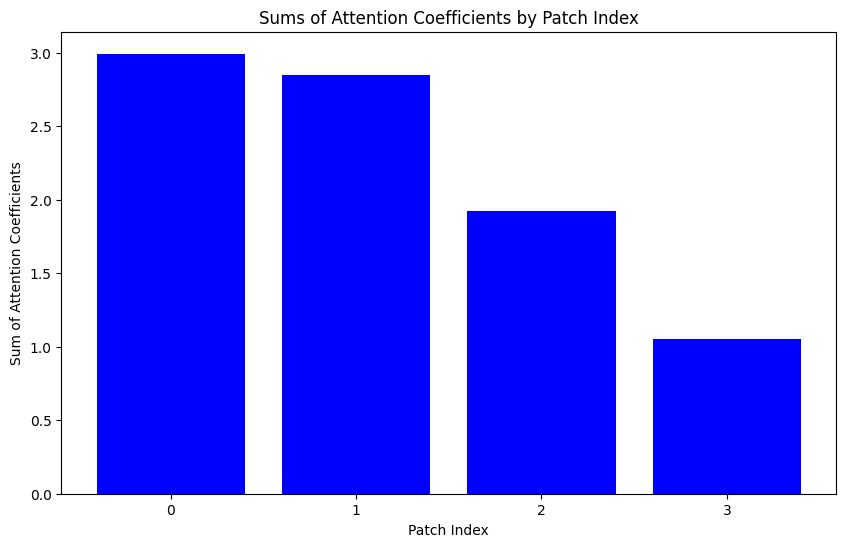

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9929)

tensor(730.1174, grad_fn=<DivBackward1>)


 60%|██████    | 6/10 [08:37<05:50, 87.57s/it]

Complete 5 th
torch.Size([283, 4, 16])
alpha: tensor([[[0.9895, 0.9108, 0.9927, 0.9971],
         [0.9953, 0.9821, 0.9926, 0.9864],
         [0.9908, 0.9143, 0.9937, 0.9977],
         [0.9913, 0.9158, 0.9942, 0.9979]],

        [[0.9948, 0.9928, 0.8765, 0.8468],
         [0.9407, 0.9919, 0.9653, 0.9473],
         [0.9643, 0.9989, 0.9420, 0.9198],
         [0.9996, 0.9689, 0.8124, 0.7784]],

        [[0.9997, 0.9979, 0.9514, 0.9912],
         [0.9936, 0.9885, 0.9221, 0.9761],
         [0.9976, 0.9941, 0.9376, 0.9846],
         [0.9999, 0.9997, 0.9627, 0.9957]],

        ...,

        [[0.9796, 0.9733, 0.9998, 0.9925],
         [0.9463, 0.9366, 0.9888, 1.0000],
         [0.9962, 0.9932, 0.9955, 0.9718],
         [0.9903, 0.9940, 0.9496, 0.8974]],

        [[0.9988, 0.9870, 0.9969, 0.9202],
         [0.9985, 0.9860, 0.9964, 0.9225],
         [0.9894, 0.9668, 0.9845, 0.9531],
         [0.9884, 0.9992, 0.9926, 0.8309]],

        [[0.9951, 0.9975, 0.9732, 0.9995],
         [0.9976, 0.9949, 0

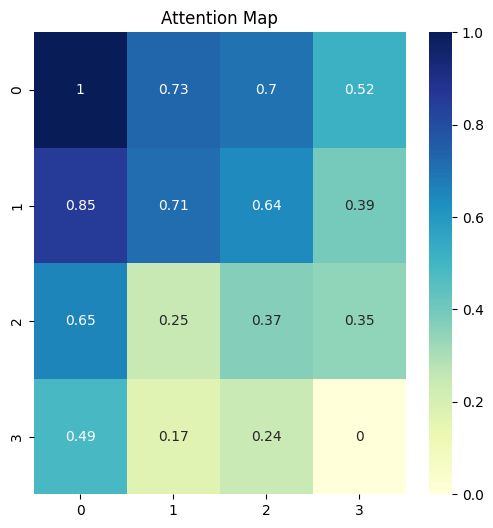

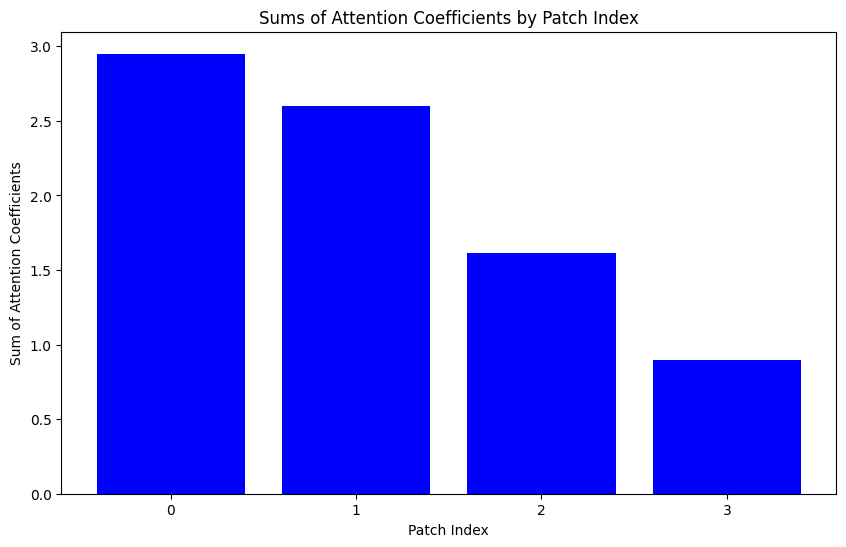

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(1.)

tensor(728.9288, grad_fn=<DivBackward1>)


 70%|███████   | 7/10 [10:06<04:24, 88.04s/it]

Complete 6 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9874, 0.8646, 0.9830, 0.9101],
         [0.9955, 0.8931, 0.9927, 0.8833],
         [0.9906, 0.9710, 0.9938, 0.7656],
         [0.9912, 0.9698, 0.9943, 0.7683]],

        [[0.9955, 0.9988, 0.9126, 0.6614],
         [0.9527, 0.9653, 0.9778, 0.7864],
         [0.9776, 0.9672, 0.7628, 0.4766],
         [0.9840, 0.9910, 0.9428, 0.7116]],

        [[0.9999, 0.9358, 0.9870, 0.9970],
         [0.9504, 0.8005, 0.8976, 0.9749],
         [0.9990, 0.9550, 0.9949, 0.9905],
         [1.0000, 0.9409, 0.9893, 0.9957]],

        ...,

        [[0.9488, 0.9737, 0.9999, 0.9380],
         [0.9965, 1.0000, 0.9744, 0.8365],
         [0.9899, 0.9988, 0.9858, 0.8647],
         [0.9291, 0.9587, 0.9974, 0.9565]],

        [[0.9999, 0.9931, 0.9996, 0.9855],
         [0.9992, 0.9980, 0.9996, 0.9749],
         [0.9825, 0.9584, 0.9801, 1.0000],
         [0.8383, 0.8866, 0.8444, 0.7378]],

        [[0.9955, 0.9807, 0.9825, 0.9433],
         [0.9937, 0.9840, 0.9857, 0.9489],
         [0.7157, 0.540

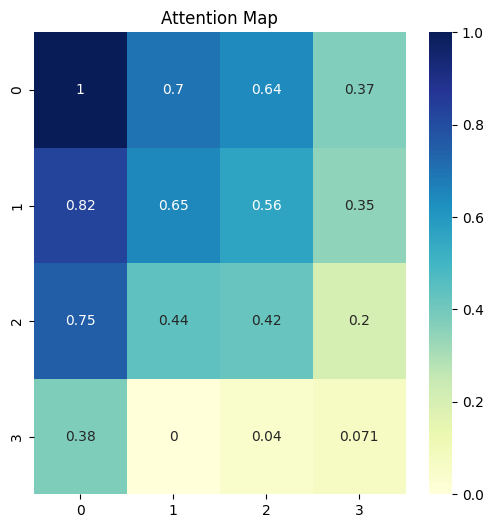

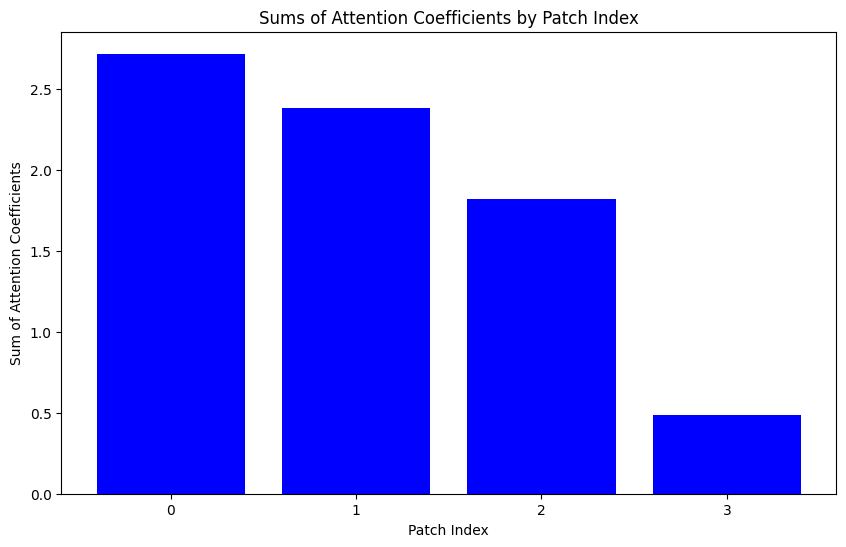

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9894)

tensor(729.1590, grad_fn=<DivBackward1>)


 80%|████████  | 8/10 [11:40<02:59, 89.88s/it]

Complete 7 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[1.0000, 0.9916, 0.9999, 0.9940],
         [0.9866, 0.9995, 0.9895, 0.9987],
         [0.9761, 0.9962, 0.9800, 0.9943],
         [0.9675, 0.9923, 0.9721, 0.9896]],

        [[0.9488, 0.9875, 0.8205, 0.6829],
         [0.9623, 0.9790, 0.8442, 0.7107],
         [0.9974, 0.9189, 0.9316, 0.8247],
         [0.9131, 0.9984, 0.7654, 0.6213]],

        [[0.9977, 0.9622, 0.9884, 0.9865],
         [0.9539, 0.9953, 0.9757, 0.9782],
         [0.9900, 0.9399, 0.9746, 0.9718],
         [0.9463, 0.9926, 0.9700, 0.9728]],

        ...,

        [[0.9998, 0.9990, 0.9787, 0.9737],
         [0.9390, 0.9300, 0.9917, 0.8513],
         [0.9587, 0.9511, 0.9979, 0.8813],
         [0.9961, 0.9934, 0.9907, 0.9557]],

        [[0.9917, 0.9770, 0.9944, 0.9796],
         [0.9991, 0.9916, 0.9817, 0.9590],
         [0.9893, 0.9982, 0.9300, 0.8919],
         [0.9976, 0.9877, 0.9865, 0.9663]],

        [[0.8714, 0.8350, 0.9634, 0.9650],
         [0.9933, 0.9992, 0.9348, 0.9327],
         [0.9757, 0.989

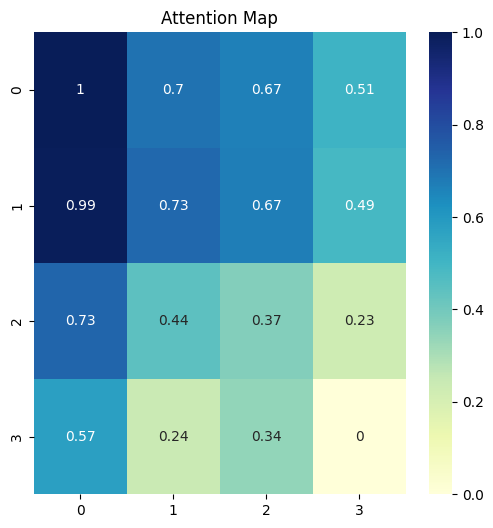

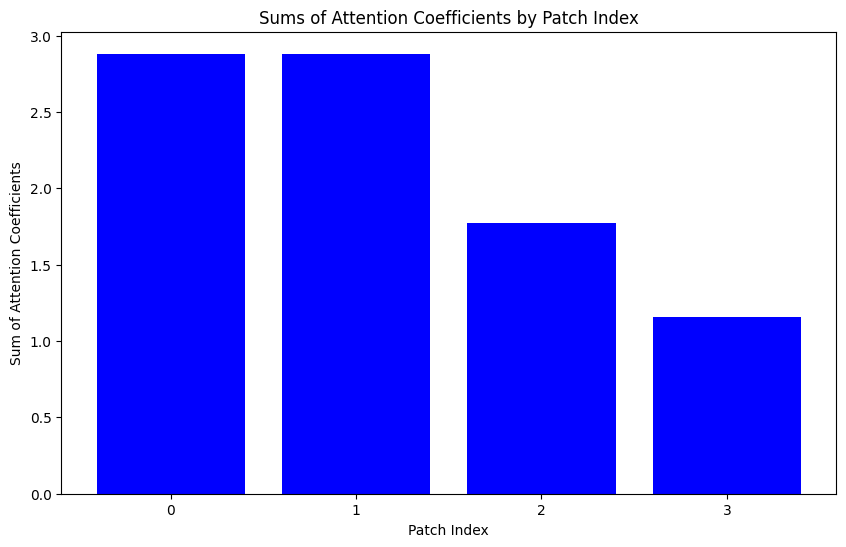

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9894)

tensor(728.9789, grad_fn=<DivBackward1>)


 90%|█████████ | 9/10 [13:25<01:34, 94.50s/it]

Complete 8 th
torch.Size([283, 4, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9564, 0.9997, 0.9946, 0.9248],
         [0.9866, 0.9939, 0.9995, 0.9665],
         [0.9931, 0.9257, 0.9523, 0.9998],
         [0.9679, 0.9998, 0.9982, 0.9399]],

        [[0.9991, 0.8627, 0.8168, 0.7646],
         [0.9101, 0.9977, 0.9872, 0.4819],
         [0.9070, 0.9982, 0.9884, 0.4773],
         [0.9971, 0.8462, 0.7986, 0.7837]],

        [[0.9954, 0.9962, 1.0000, 0.9136],
         [0.9893, 0.9879, 0.9707, 0.9835],
         [0.9965, 0.9972, 0.9999, 0.9183],
         [0.7813, 0.7762, 0.7262, 0.9325]],

        ...,

        [[0.8867, 0.9486, 0.9842, 0.8598],
         [0.8657, 0.9334, 0.9750, 0.8372],
         [0.9544, 0.9903, 1.0000, 0.9356],
         [0.9722, 0.9974, 0.9972, 0.9570]],

        [[0.9991, 0.9999, 0.9981, 0.9919],
         [0.9998, 0.9989, 1.0000, 0.9980],
         [0.8820, 0.8710, 0.8909, 0.9173],
         [0.9833, 0.9874, 0.9794, 0.9644]],

        [[0.9722, 0.9998, 0.9049, 1.0000],
         [0.9888, 0.9978, 0.9374, 0.9968],
         [0.6542, 0.780

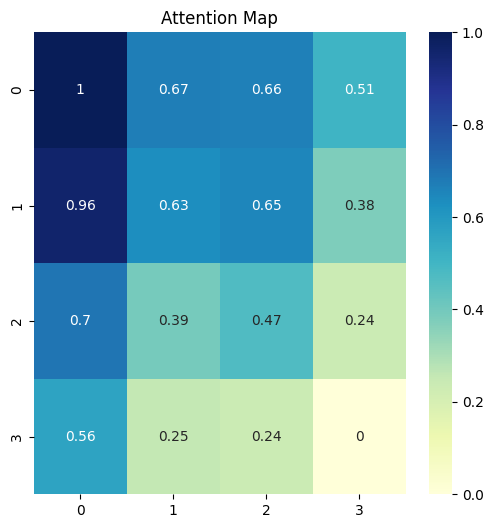

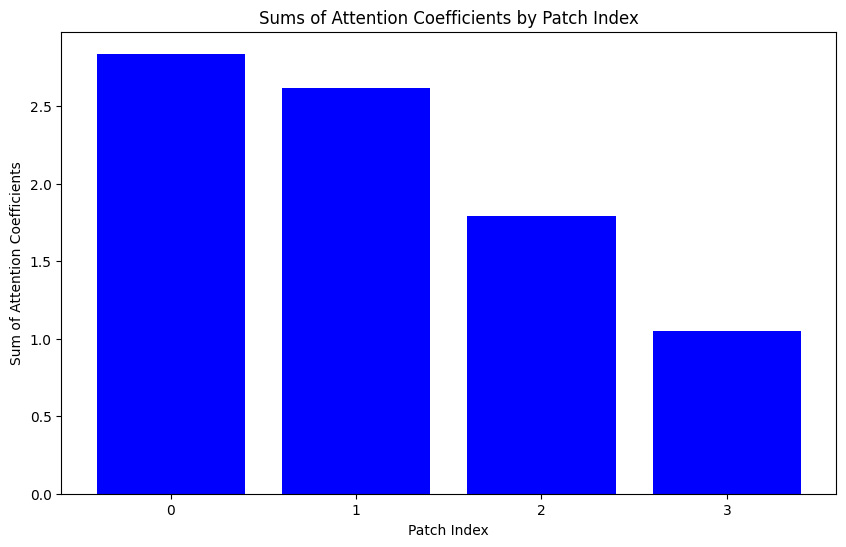

Q_output size: torch.Size([4, 283, 4])
K_output size: torch.Size([4, 283, 4])
V_output size: torch.Size([283, 4, 16])


/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9929)

tensor(728.0668, grad_fn=<DivBackward1>)


100%|██████████| 10/10 [14:58<00:00, 89.89s/it]

Complete 9 th


In [20]:
for iepoch in tqdm(range(10)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    print("Complete "+str(iepoch)+" th")

torch.Size([78, 4, 16])
alpha: tensor([[[1.0000, 0.9986, 0.8846, 1.0000],
         [0.9911, 0.9828, 0.9365, 0.9913],
         [0.9954, 0.9990, 0.8391, 0.9952],
         [0.9815, 0.9902, 0.7886, 0.9812]],

        [[0.9968, 0.9742, 0.9980, 0.9336],
         [0.9995, 0.9434, 0.9987, 0.8896],
         [0.9975, 0.9306, 0.9961, 0.8729],
         [0.9377, 0.9988, 0.9436, 0.9957]],

        [[0.9245, 0.9363, 0.6802, 0.9404],
         [0.9990, 0.9969, 0.9093, 0.9958],
         [0.9996, 0.9980, 0.9030, 0.9971],
         [0.9940, 0.9898, 0.9332, 0.9880]],

        ...,

        [[0.7956, 0.9807, 0.8439, 0.9840],
         [0.8753, 0.9993, 0.7589, 0.9998],
         [0.9781, 0.9646, 0.5772, 0.9598],
         [0.8279, 0.9908, 0.8126, 0.9931]],

        [[0.9702, 0.9647, 0.9999, 0.9979],
         [0.9982, 0.9993, 0.9491, 0.9712],
         [0.8522, 0.8412, 0.9552, 0.9289],
         [0.9998, 1.0000, 0.9607, 0.9799]],

        [[0.9979, 0.9634, 0.7733, 0.9959],
         [0.9996, 0.9535, 0.7927, 0.9921],

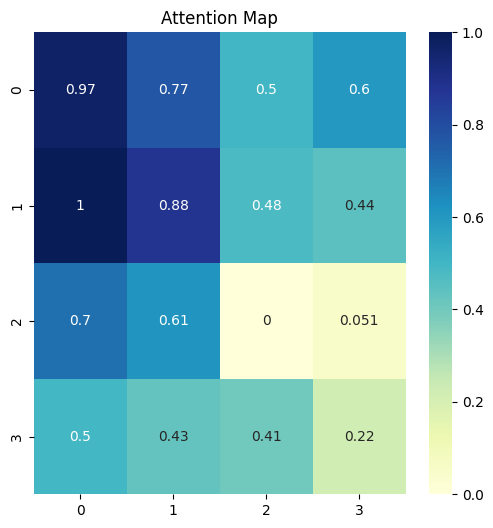

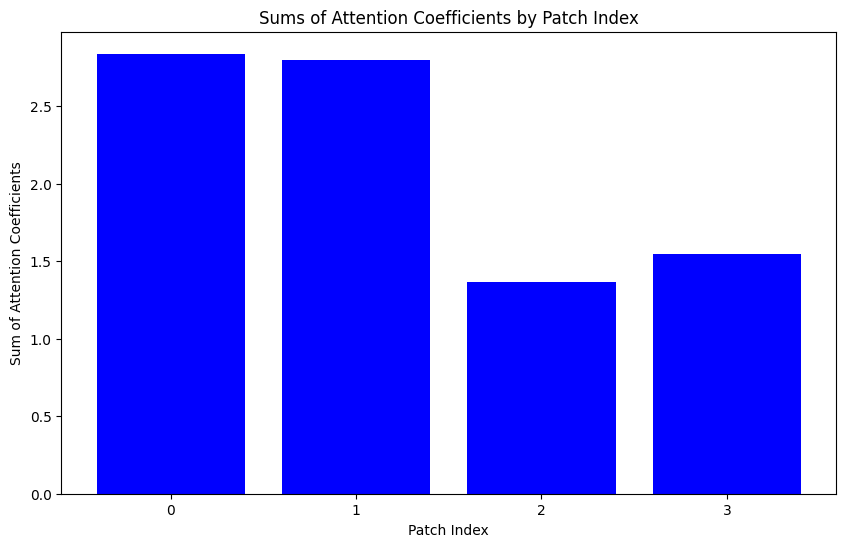

Q_output size: torch.Size([4, 78, 4])
K_output size: torch.Size([4, 78, 4])
V_output size: torch.Size([78, 4, 16])

Accuracy: 1.0

Loss: 164.38140869140625

AUROC: 1.0



/tmp/ipykernel_91552/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [21]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------